In [0]:
# mount della cartella di Google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# unzip data e clean
!unzip -a "drive/My Drive/IPCV/DATASET_TRAY_FOOD/tray-food-segmentation.zip" -d "dataset"
!rm -rf image-dataset/__MACOSX # rimuovo una cartella inutile creata con lo zip

Archive:  drive/My Drive/IPCV/DATASET_TRAY_FOOD/tray-food-segmentation.zip
  inflating: dataset/TrayDataset/TrayDataset/XTest/1005a.jpg  [binary]
  inflating: dataset/TrayDataset/TrayDataset/XTest/2002a.jpg  [binary]
  inflating: dataset/TrayDataset/TrayDataset/XTest/3004a.jpg  [binary]
  inflating: dataset/TrayDataset/TrayDataset/XTest/4003a.jpg  [binary]
  inflating: dataset/TrayDataset/TrayDataset/XTest/5006a.jpg  [binary]
  inflating: dataset/TrayDataset/TrayDataset/XTest/6004a.jpg  [binary]
  inflating: dataset/TrayDataset/TrayDataset/XTest/7010a.jpg  [binary]
  inflating: dataset/TrayDataset/TrayDataset/XTest/8006a.jpg  [binary]
  inflating: dataset/TrayDataset/TrayDataset/XTrain/1001a01.jpg  [binary]
  inflating: dataset/TrayDataset/TrayDataset/XTrain/1001a02.jpg  [binary]
  inflating: dataset/TrayDataset/TrayDataset/XTrain/1001a03.jpg  [binary]
  inflating: dataset/TrayDataset/TrayDataset/XTrain/1001a04.jpg  [binary]
  inflating: dataset/TrayDataset/TrayDataset/XTrain/1001a05.j

In [0]:
# installazione libreria utility
!pip install -U segmentation-models

In [0]:
# upgrade ram
a = []
while(1):
    a.append('1'*100000)

In [0]:
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0]
print(gpu.name)

ModuleNotFoundError: ignored

In [0]:
# import basilari
%tensorflow_version 1.x
import pandas as pd
import numpy as np
from numpy.random import uniform
import tensorflow as tf
import keras.backend as K
import segmentation_models as sm
import matplotlib.pyplot as plt
import scipy.io as sio
from imageio import imread
from os import listdir
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.optimizers import Adam
from google.colab import files

TensorFlow 1.x selected.


Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [0]:
path = './dataset/'
data_class =pd.read_csv(path+'classes.csv')
data_class.head()

,_id,_class,_name
0,0,background,background
1,1,tray,tray
2,2,cutlery,cutlery
3,3,form,form
4,4,straw,straw


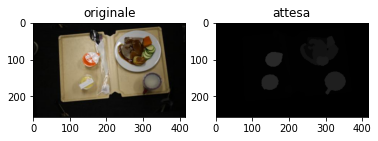

In [0]:
# visualizzo una img da x_train e 
originale = imread(path+'TrayDataset/TrayDataset/XTrain/1001a03.jpg')
attesa = imread(path+'TrayDataset/TrayDataset/yTrain/1001a03.png')
plt.subplot(1,2,1); plt.imshow(originale); plt.title('originale');
plt.subplot(1,2,2); plt.imshow(attesa); plt.title('attesa');

In [0]:
# Definizione backbone, caricamento IO, e preprocess dell'input
# BACKBONE = 'inceptionv3' -> AGOSTINO
# BACKBONE = 'VGG19' -> VINCENZO
# BACKBONE MIA 1 = 'resnet34' -> Valori di accuracy troppo bassa
# BACKBONE MIA 2 = 'resnet50' -> Da provate
# BACKBONE MIA 3 = 'densenet201' -> val_accuracy = 0.94 , iou_coeff = 0.9
# BACKBONE MIA 4 = 'densenet169' -> val_accuracy = 0.93 , iou_coeff = 0.89
# MODEL = LINKNET | BACKBONE = 'vgg19' -> val_accuracy = 0.98 , iou_coeff = 0.96
BACKBONE = 'vgg19'
preprocess_input = sm.get_preprocessing(BACKBONE) # attenzione, non utilizzata -> da problemi!

# load your data
x_train_val = []
for image in listdir(path+'TrayDataset/TrayDataset/XTrain/'):
    x_train_val.append((image,imread(path+'TrayDataset/TrayDataset/XTrain/'+image),image[0]))
                                       
y_train_val =[]
for image in listdir(path+'TrayDataset/TrayDataset/yTrain/'):
    y_train_val.append((image,imread(path+'TrayDataset/TrayDataset/yTrain/'+image),image[0]))
    

In [0]:
# ordino i due vettori e ricontrollo
x_train_val.sort(key = lambda x: x[0])
y_train_val.sort(key = lambda x: x[0])
x_Train_Val = [i[1] for i in x_train_val]
y_Train_Val = [i[1] for i in y_train_val]

# mi prendo i label per fare una stratificazione
x_label = [i[2] for i in x_train_val]

del x_train_val
del y_train_val
# riduco in 0-1

x_Train_Val = np.array(x_Train_Val).astype('float32')/255
# splitto in training e validation -> aggiunta stratificazione sul label elemento[0] del nome img
X_train, X_val, y_train, y_val = train_test_split(x_Train_Val, y_Train_Val, test_size=0.25, random_state=17, stratify = x_label)
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

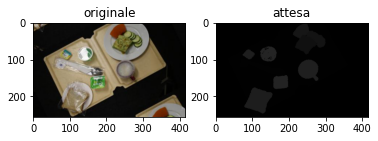

In [0]:
#visualizzo
plt.subplot(1,2,1); plt.imshow(X_train[0]); plt.title('originale');
plt.subplot(1,2,2); plt.imshow(y_train[0]); plt.title('attesa');

In [0]:
# verifico la dimensione del X_train e X_val
print(str(X_train.shape)+ ' '+ str(X_val.shape)+' '+str(type(X_train)))

(930, 256, 416, 3) (311, 256, 416, 3) <class 'numpy.ndarray'>


In [0]:
def one_hot_it(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    #print('Start One-Hot Vectorizing...')
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    #print('Done..')
    return semantic_map

In [0]:
background=[0,0,0]
tray=[1,1,1]
cutler=[2,2,2]
form=[3,3,3]
straw=[4,4,4]
meatball=[5,5,5]
beef=[6,6,6]
roastlamb=[7,7,7]
beeftomatocasserole=[8,8,8]
ham=[9,9,9]
bean=[10,10,10]
cucumber=[11,11,11]
leaf=[12,12,12]
tomato=[13,13,13]
boiledrice=[14,14,14]
beefmexicanmeatballs=[15,15,15]
spinachandpumpkinrisotto=[16,16,16]
bakedfish=[17,17,17]
gravy=[18,18,18]
zucchini=[19,19,19]
carrot=[20,20,20]
broccoli=[21,21,21]
pumpkin=[22,22,22]
celery=[23,23,23]
sandwich=[24,24,24]
sidesalad=[25,25,25]
tartaresauce=[26,26,26]
jacketpotato=[27,27,27]
creamedpotato=[28,28,28]
bread=[29,29,29]
margarine=[30,30,30]
soup=[31,31,31]
apple=[32,32,32]
cannedfruit=[33,33,33]
milk=[34,34,34]
vanillayogurt=[35,35,35]
jelly=[36,36,36]
custard=[37,37,37]
lemonsponge=[38,38,38]
juice=[39,39,39]
applejuice=[40,40,40]
orangejuice=[41,41,41]
water=[42,42,42]

# We dont want to classify unlabelled.it will only make our dataset more unbalanced than it already is
label_values = [background,tray,cutler,form,straw,meatball,beef,roastlamb,beeftomatocasserole,ham,bean,cucumber,leaf,tomato,boiledrice,
beefmexicanmeatballs,spinachandpumpkinrisotto,bakedfish,gravy,zucchini,carrot,broccoli,pumpkin,celery,sandwich,sidesalad,
tartaresauce,jacketpotato,creamedpotato,bread,margarine,soup,apple,cannedfruit,milk,vanillayogurt,jelly,custard,lemonsponge,
juice,applejuice,orangejuice,water]

In [0]:
y_train_norm = np.array([one_hot_it(y_train[i],label_values) for i in range(len(y_train))])
del y_train
y_val_norm = np.array([one_hot_it(y_val[i],label_values) for i in range(len(y_val))])
del y_val

In [0]:
###### definizione loss e iou
"""
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
  union = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1) - intersection
  return (intersection+smooth)/(union+smooth)
# verificato -> problema
"""
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3]) # ottiene un numero per ogni img 
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou # => verificato...  dovrebbe funzionare correttamente

#    IoU = (|X &amp; Y|)/ (|X or Y|)
def iou_coef_loss(y_true, y_pred):
  return -iou_coef(y_true, y_pred)

In [0]:
# ricerca hpam <-> Coarse to fine classica
COARSE_TRAIN_EPOCHS = 5
FINER_TRAIN_EPOCHS = 20 # chiamato epochs dopo
MAX_RANGE = 15

In [0]:
# define model
meanIOU = tf.keras.metrics.MeanIoU(num_classes=43)
for i in range(0,MAX_RANGE):

  lr = 10**uniform(-3,-2) # COARSE TO FINE [COARSE] => NEW INTERVAL: -3, -2 <-> OLD INTERVAL : -7 -1 
  # lr = ... # FINER 
  adam = Adam(learning_rate = lr)
  #model = sm.Unet(BACKBONE, encoder_weights='imagenet', input_shape = (256, 416, 3), encoder_freeze = True, classes=43, activation='softmax')
  model = sm.Linknet(BACKBONE, encoder_weights='imagenet', input_shape = (256, 416, 3), encoder_freeze = True, classes=43, activation='softmax')
  model.compile(
      adam,
      loss=sm.losses.JaccardLoss(), #loss = 'categorical_crossentropy',
      metrics = ['accuracy', sm.metrics.IOUScore(), meanIOU, iou_coef] # metrics=[sm.metrics.iou_score]
      )
  if i == 0:
    print(model.summary()) # model.summary() non visualizzo sempre per comodità 
  print('********** lr = '+str(lr)+' **********')
  model.fit(
      x=X_train,
      y=y_train_norm,
      batch_size=10,
      epochs=COARSE_TRAIN_EPOCHS,
      validation_data=(X_val,y_val_norm))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

80142336/80134624 [==============================] - 2s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 416, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 416, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 416, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 

In [0]:
# fit model <-> LONG Time If needed
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
EPOCHS = 60
n_classes = 43
lr = 0.0018356298437779055 
meanIOU = tf.keras.metrics.MeanIoU(n_classes)
adam = Adam(learning_rate=lr)   #migliore lr trovato
model = sm.Unet(BACKBONE, encoder_weights='imagenet', input_shape = (256, 416, 3), encoder_freeze = True, classes=43, activation='softmax')
model.compile(
    adam,
    loss=sm.losses.JaccardLoss(), #loss = 'categorical_crossentropy',
    metrics = ['accuracy', sm.metrics.IOUScore(), meanIOU, iou_coef] # metrics=[sm.metrics.iou_score]
    )
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

80142336/80134624 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 416, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 416, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 416, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 

In [0]:
checkpoint_filepath = './chekpoint'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor=['val_accuracy', 'val_iou_coef'],
    mode='max',
    save_best_only=True)

In [0]:
model.fit(
   x=X_train,
   y=y_train_norm,
   batch_size=12,
   epochs=EPOCHS,
   validation_data=(X_val,y_val_norm),
   verbose=2)
model.save('./LinkNET-densenet169[best].h5');


Train on 930 samples, validate on 311 samples
Epoch 1/60
 - 160s - loss: 0.9104 - accuracy: 0.6926 - iou_score: 0.0903 - mean_io_u: 0.4884 - iou_coef: 0.3131 - val_loss: 0.9942 - val_accuracy: 0.0222 - val_iou_score: 0.0058 - val_mean_io_u: 0.4889 - val_iou_coef: 0.0114
Epoch 2/60
 - 136s - loss: 0.7442 - accuracy: 0.9120 - iou_score: 0.2563 - mean_io_u: 0.4891 - iou_coef: 0.8248 - val_loss: 0.9599 - val_accuracy: 0.2982 - val_iou_score: 0.0402 - val_mean_io_u: 0.4896 - val_iou_coef: 0.1476
Epoch 3/60
 - 135s - loss: 0.6013 - accuracy: 0.9529 - iou_score: 0.3983 - mean_io_u: 0.4902 - iou_coef: 0.9072 - val_loss: 0.8000 - val_accuracy: 0.8155 - val_iou_score: 0.2000 - val_mean_io_u: 0.4911 - val_iou_coef: 0.6688
Epoch 4/60
 - 134s - loss: 0.5381 - accuracy: 0.9638 - iou_score: 0.4621 - mean_io_u: 0.4923 - iou_coef: 0.9295 - val_loss: 0.6325 - val_accuracy: 0.9252 - val_iou_score: 0.3675 - val_mean_io_u: 0.4936 - val_iou_coef: 0.8547
Epoch 5/60
 - 135s - loss: 0.5116 - accuracy: 0.9696 

In [0]:
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values
        
    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [0]:
def plot_predictions(X_test,preds,path):
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,5))
    ax[0].imshow(X_test,aspect="auto")
    ax[0].set_title("Input")
    ax[1].imshow(preds, aspect="auto")
    ax[1].set_title("Prediction")
    fig.tight_layout()

In [0]:
#Make predictions
y_prob = model.predict(X_val)

#Output the most probable classes based on predictions
y_classes = y_prob.argmax(axis=-1)

#Reshape our classes in order to proceed with visualizing our predictions
y_classes = y_classes.reshape(y_classes.shape[0],256,416)

#segment = colour_code_segmentation(y_classes,label_values)
#segment=np.squeeze(segment,axis=3)

plot_predictions(X_val[1],y_classes[1],path="3")

In [0]:
plot_predictions(X_val[3],y_classes[3],path="3")

In [0]:
plot_predictions(X_val[30],y_classes[30],path="3")

In [0]:
plot_predictions(X_val[35],y_classes[35],path="3")

In [0]:
plot_predictions(X_val[43],y_classes[43],path="3")

In [0]:
plot_predictions(X_val[13],y_classes[13],path="3")

In [0]:
plot_predictions(X_val[37],y_classes[37],path="3")

NameError: ignored

In [0]:
plot_predictions(X_val[39],y_classes[39],path="3")

In [0]:
y_classes.shape

In [0]:
y_classes[39,100,300]

In [0]:
y_classes[37,100,100]